In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import tifffile
import pre_process_mm as pre
import mm3_adapted_cell_segmentation as mm3seg
import mm3_adapted_cell_tracking as mm3track
import plot_cells
import warnings
import networkx as nx

In [4]:
seg_FOV_dict = {'DUMM_giTG62_Glucose_012925': 
            {'005': ['2421']
            }
           }

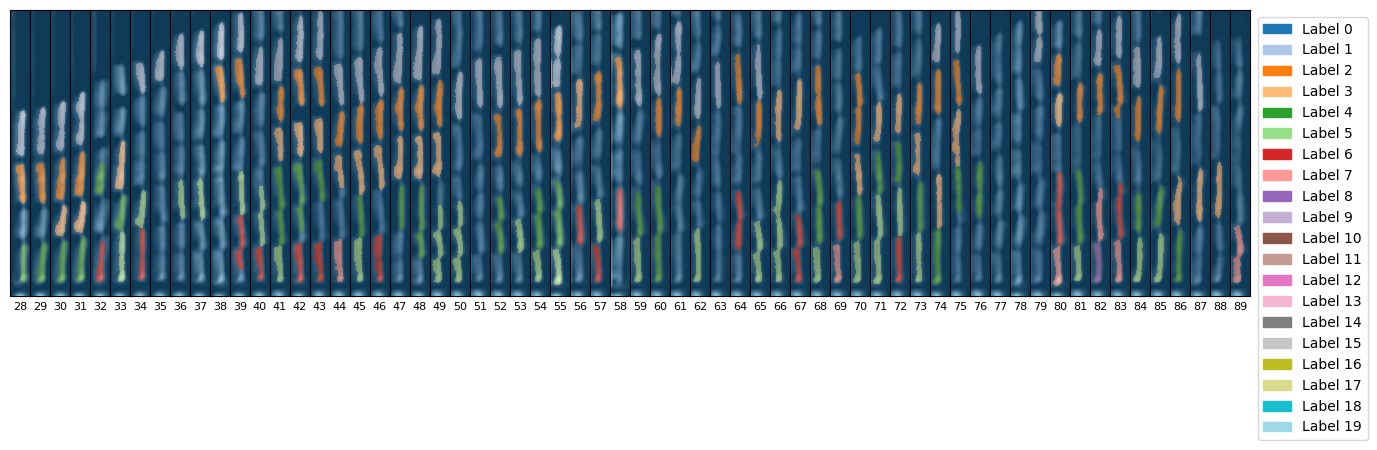

In [5]:
phase_channel = '0'
fluor_channel = '1'
for folder, fov_dict in seg_FOV_dict.items():
    for fov_id in fov_dict.keys():
        ana_peak_ids = fov_dict[fov_id]
        for peak_id in ana_peak_ids:
            path_to_phase_stack = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/subtracted_FOV_{fov_id}_region_{peak_id}_c_{phase_channel}.tif'
            path_to_fluor_stack = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/subtracted_FOV_{fov_id}_region_{peak_id}_c_{fluor_channel}.tif'
            output_path = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/outputs'
            mm3seg.segment_chnl_stack(path_to_phase_stack,
                   output_path,
                   OTSU_threshold=1.5,
                   first_opening=2,
                   distance_threshold=1,
                   second_opening_size=1,
                   min_cell_area=200,
				   max_cell_area=600,
                   small_merge_area_threshold=200)
            labeled_stack = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/mm3_segmented_subtracted_FOV_{fov_id}_region_{peak_id}_c_{phase_channel}.tif'
            plot_cells.display_segmentation(path_to_phase_stack, mask_path = labeled_stack, start=28, end=90, alpha=0.5)

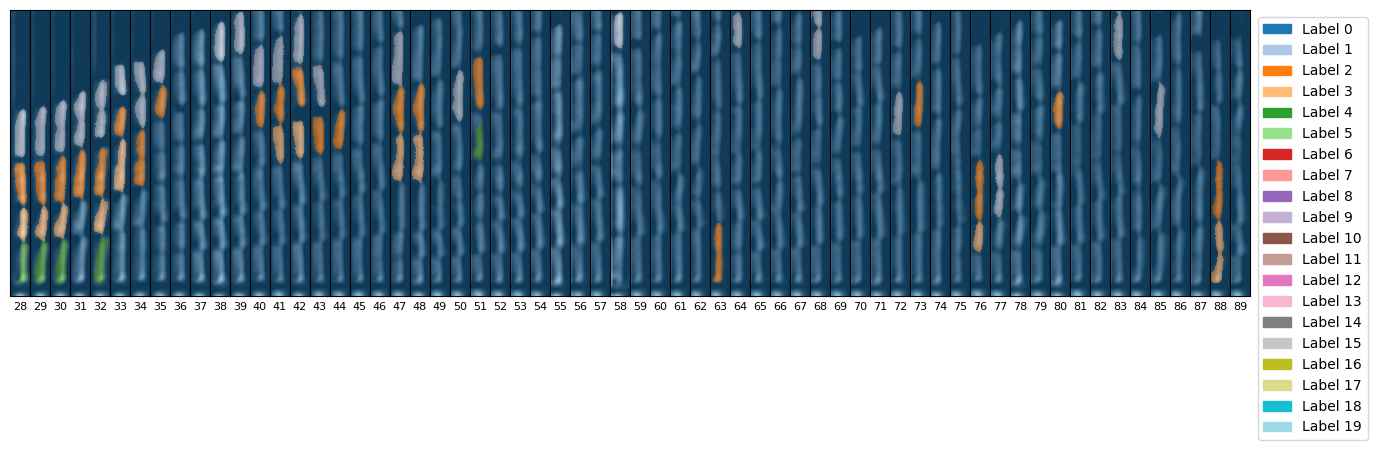

In [6]:
for folder, fov_dict in seg_FOV_dict.items():
    for fov_id in fov_dict.keys():
        ana_peak_ids = fov_dict[fov_id]
        for peak_id in ana_peak_ids:
            path_to_phase_stack = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/subtracted_FOV_{fov_id}_region_{peak_id}_c_{phase_channel}.tif'
            path_to_fluor_stack = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/subtracted_FOV_{fov_id}_region_{peak_id}_c_{fluor_channel}.tif'
            output_path = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/outputs'
            mm3seg.segment_chnl_stack(path_to_phase_stack,
                   output_path,
                   OTSU_threshold=1,
                   first_opening=2,
                   distance_threshold=1,
                   second_opening_size=1,
                   min_cell_area=200,
				   max_cell_area=600,
                   small_merge_area_threshold=200)
            labeled_stack = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/mm3_segmented_subtracted_FOV_{fov_id}_region_{peak_id}_c_{phase_channel}.tif'
            plot_cells.display_segmentation(path_to_phase_stack, mask_path = labeled_stack, start=28, end=90, alpha=0.5)

# Troubleshoot segmentation function to increase cell detection

In [7]:
from skimage import segmentation, morphology, measure
from skimage.filters import threshold_otsu
from scipy import ndimage as ndi

In [59]:
def segment_image(image,
                  OTSU_threshold=1.5,
                  first_opening=5,
                  distance_threshold=3,
                  second_opening_size=1,
                  min_cell_area=200,
                  max_cell_area=700,
                  small_merge_area_threshold=50):
    """Segments an image with size filtering and improved structure."""

    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            thresh = threshold_otsu(image)
    except Exception as e:
        print(f"Error in thresholding: {e}")
        return np.zeros_like(image)

    thresholded = image > OTSU_threshold * thresh

    morph = morphology.binary_opening(thresholded, morphology.disk(first_opening))

    if np.amax(morph) == 0:
        return np.zeros_like(image)

    distance = ndi.distance_transform_edt(morph)

    distance_thresh = distance >= distance_threshold

    distance_opened = morphology.binary_opening(distance_thresh, morphology.disk(second_opening_size))

    #cleared = segmentation.clear_border(distance_opened)

    #labeled, num_labels = morphology.label(cleared, connectivity=1, return_num=True)
    labeled, num_labels = morphology.label(distance_opened, connectivity=1, return_num=True)

    if num_labels == 0:
        return np.zeros_like(image)

    markers = morphology.label(labeled, connectivity=1)

    if np.amax(markers) == 0:
        return np.zeros_like(image)
    thresholded_watershed = thresholded

    try:
        markers[thresholded_watershed == 0] = -1
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            labeled_image = segmentation.random_walker(-1 * image, markers)
        labeled_image[labeled_image == -1] = 0
    except:
        return np.zeros_like(image)
    

    # Bounding Box Merging
    regions = measure.regionprops(labeled_image)
    if regions:
        bboxes = np.array([region.bbox for region in regions])
        areas = np.array([region.area for region in regions])
        graph = nx.Graph()
        for i, bbox1 in enumerate(bboxes):
            for j, bbox2 in enumerate(bboxes):
                if i != j and overlap(bbox1, bbox2) and areas[i] < small_merge_area_threshold and areas[j] < small_merge_area_threshold:
                    graph.add_edge(regions[i].label, regions[j].label)

        # Find connected components (merged regions)
        for component in nx.connected_components(graph):
            if len(component) > 1:  # Only merge if there's more than one region
                merged_mask = np.isin(labeled_image, list(component))
                new_label = np.max(labeled_image) + 1
                labeled_image[merged_mask] = new_label

                for label in component:
                    labeled_image[labeled_image == label] = 0

        # Relabel after merging
        labeled_image, num_labels = morphology.label(labeled_image, connectivity=1, return_num=True)
    

    # Size Filtering
    if min_cell_area is not None or max_cell_area is not None:
        filtered_labeled_image = np.zeros_like(labeled_image)
        regions = measure.regionprops(labeled_image)
        for region in regions:
            area = region.area
            if (min_cell_area is None or area >= min_cell_area) and (max_cell_area is None or area <= max_cell_area):
                filtered_labeled_image[region.coords[:, 0], region.coords[:, 1]] = region.label

        labeled_image = filtered_labeled_image

    return labeled_image

In [40]:
def segment_chnl_stack(path_to_phase_channel_stack,
					   output_path,
					   OTSU_threshold=1.5,
					   first_opening=5,
					   distance_threshold=3,
					   second_opening_size=1,
					   min_cell_area=100,
					   max_cell_area=700,
					   small_merge_area_threshold=50):
	"""
	For a given fov and peak (channel), do segmentation for all images in the
	subtracted .tif stack.
	Adapted from napari-mm3
	"""

	path_to_mm3_seg = os.path.join(output_path, 'mm3_segmentation')
	os.makedirs(path_to_mm3_seg, exist_ok=True)

	save_to_path = os.path.dirname(path_to_phase_channel_stack)
	filename = os.path.basename(path_to_phase_channel_stack)
	phase_stack = tifffile.imread(path_to_phase_channel_stack)


	# image by image for debug
	segmented_imgs = []
	for time in range(phase_stack.shape[0]):
		unstacked_seg_image = segment_image(phase_stack[time, :, :],
											OTSU_threshold,
											first_opening,
											distance_threshold,
											second_opening_size,
											min_cell_area,
											max_cell_area,
											small_merge_area_threshold)

		unstacked_seg_image = unstacked_seg_image.astype("uint8")
		unstacked_seg_filename = f'mask{time:03d}.tiff'
		unstacked_path = os.path.join(path_to_mm3_seg, unstacked_seg_filename)
		tifffile.imwrite(unstacked_path, unstacked_seg_image)

		segmented_imgs.append(unstacked_seg_image)

	# stack them up along a time axis
	segmented_imgs = np.stack(segmented_imgs, axis=0)


	seg_filename = f'mm3_segmented_{filename}'
	path = os.path.join(save_to_path, seg_filename)
	tifffile.imwrite(path, segmented_imgs)

In [41]:
def overlap(bbox1, bbox2):
    """Checks if two bounding boxes overlap."""
    x1 = max(bbox1[0], bbox2[0])
    y1 = max(bbox1[1], bbox2[1])
    x2 = min(bbox1[2], bbox2[2])
    y2 = min(bbox1[3], bbox2[3])
    return x1 < x2 and y1 < y2


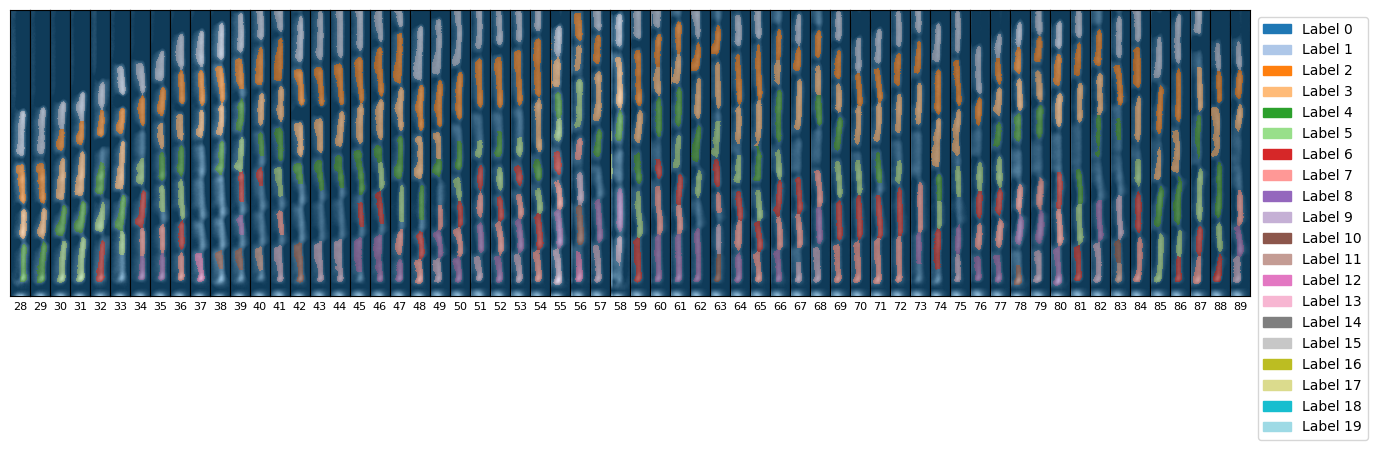

In [63]:
for folder, fov_dict in seg_FOV_dict.items():
    for fov_id in fov_dict.keys():
        ana_peak_ids = fov_dict[fov_id]
        for peak_id in ana_peak_ids:
            path_to_phase_stack = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/subtracted_FOV_{fov_id}_region_{peak_id}_c_{phase_channel}.tif'
            path_to_fluor_stack = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/subtracted_FOV_{fov_id}_region_{peak_id}_c_{fluor_channel}.tif'
            output_path = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/outputs'
            segment_chnl_stack(path_to_phase_stack,
                   output_path,
                   OTSU_threshold=1.5,
                   first_opening=1,
                   distance_threshold=1.5,
                   second_opening_size=1,
                   min_cell_area=100,
				   max_cell_area=600,
                   small_merge_area_threshold=50)
            labeled_stack = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/mm3_segmented_subtracted_FOV_{fov_id}_region_{peak_id}_c_{phase_channel}.tif'
            plot_cells.display_segmentation(path_to_phase_stack, mask_path = labeled_stack, start=28, end=90, alpha=0.5)